In [26]:
import sys
sys.path.append('../../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set
import matplotlib.pyplot as plt
from matplotlib import rc

In [27]:
_time_intervals = 7  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 48  # Number of execution scenarios                     (chi)
M = 1e4  # Big M

loc6_varying_factor = pandas.DataFrame(data={'com1_process': [1]*48})

# Define temporal scales
scales = TemporalScale(discretization_list=[_exec_scenarios, _time_intervals])

In [28]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================
com1_pur = Resource(name='com1_pur', cons_max=75, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system')

com1_in = Resource(name='com1_in', label='Commodity 1 received')
com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [29]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_process_capacity = 125

com1_procure = Process(name='procure com1', prod_max=125, conversion={com1_pur: -1, com1_in: 1}, capex=0.01, vopex=0.01, prod_min=125, label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 4')
com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 5')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},  capex=0.01, vopex=0.01, prod_min=com1_process_capacity, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')

# com1_process = Process(name='com1_process', prod_max=prod_max, conversion={0:{com1_in: -1, com1_out: 1}, 1:{com1_in: -1, com1_out: 1}, 2:{com1_in: -1, com1_out: 1}},  capex=0.01, vopex=0.01, prod_min=prod_min, rate_max=rate_max, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', prod_max=com1_process_capacity, capex=100, vopex=1, store_min=0.01, store_max= 20, prod_min=com1_process_capacity, label="Storage capacity of 10 units", storage=com1_in, storage_cost=0.02)
com1_store20 = Process(name='com1_store20', prod_max=com1_process_capacity, capex=200, vopex=2, store_min=0.01,store_max= 40, prod_min=com1_process_capacity, label="Storage capacity of 20 units", storage=com1_in, storage_cost=0.02)
com1_store50 = Process(name='com1_store50', prod_max=com1_process_capacity, capex=500, vopex=5, store_min=0.01, store_max= 100, prod_min=com1_process_capacity, label="Storage capacity of 50 units", storage=com1_in, storage_cost=0.02)

com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 2')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 3')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 4')
com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 5')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 6')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.01, vopex=0.01, prod_min=com1_process_capacity, label='Send commodity one from location 7')

In [30]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=1, capacity_scale_level=0, availability_scale_level=0)

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1, capacity_scale_level=0, availability_scale_level=0)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=1, capacity_scale_level=0, availability_scale_level=0)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=1, capacity_scale_level=0, availability_scale_level=0)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1, capacity_scale_level=0, availability_scale_level=0)

loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=1, capacity_scale_level=0, availability_scale_level=0, capacity_factor={com1_process: loc6_varying_factor[['com1_process']]})

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=1, capacity_scale_level=0, availability_scale_level=0)

In [31]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================

truck_cap12 = 70
truck_cap13 = 30
truck_cap24 = 50
truck_cap25 = 30
truck_cap34 = 30
truck_cap45 = 100
truck_cap47 = 40
truck_cap64 = 50
truck_cap75 = 40

truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12, label='Truck from location 1 to 2', capex=0.5, vopex=0.05, trans_min=truck_cap12)
truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_cap12, speed=50)

truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13, label='Truck from location 1 to 3', capex=0.3, vopex=0.03, trans_min=truck_cap13, speed=50)
truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_cap13, speed=50)

truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24, label='Truck from location 2 to 4', capex=0.5, vopex=0.05, trans_min=truck_cap24, speed=50)
truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_cap24, speed=50)

truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25, label='Truck from location 2 to 5', capex=0.3, vopex=0.03, trans_min=truck_cap25, speed=50)
truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_cap25, speed=50)

truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34, label='Truck from location 3 to 4', capex=0.2, vopex=0.02, trans_min=truck_cap34, speed=50)
truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_cap34, speed=50)

truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45, label='Truck from location 4 to 5', capex=1, vopex=0.1, trans_min=truck_cap45, speed=50)
truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_cap45, speed=50)

truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47, label='Truck from location 4 to 7', capex=0.4, vopex=0.04, trans_min=truck_cap47, speed=50)
truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_cap47, speed=50)

truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64, label='Truck from location 6 to 4', capex=0.5, vopex=0.05, trans_min=truck_cap64, speed=50)
truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_cap64, speed=50)

truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75, label='Truck from location 7 to 5', capex=0.4, vopex=0.04, trans_min=truck_cap75, speed=50)
truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_cap75, speed=50)

In [32]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================

# transport_matrix = [
#     [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
#     [[truck50_21], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
#     [[truck30_31], [], [], [truck20_34], [], [], []],  # source: location 3
#     [[], [truck50_42], [truck20_43], [], [truck100_45], [truck50_46], [truck40_47]],  # source: location 4
#     [[], [truck30_52], [], [truck100_54], [], [], [truck40_57]],  # source: location 5
#     [[], [], [], [truck50_64], [], [], []],  # source: location 6
#     [[], [], [], [truck40_74], [truck40_75], [], []]  # source: location 7
# ]

transport_matrix = [
    [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    [[], [], [], [truck64], [], [], []],  # source: location 6
    [[], [], [], [truck74], [truck75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)


In [33]:
daily_demand = 100
demand_penalty = 500

demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}

scenario = Scenario(name='scenario_baseline', scales=scales, scheduling_scale_level=1, network_scale_level=0, purchase_scale_level=1, availability_scale_level=0, demand_scale_level=1, capacity_scale_level=0, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Baseline Scenario')

In [34]:
problem_mincost = formulate(scenario=scenario,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND, Constraints.MODE},
                            # constraints={Constraints.RESOURCE_BALANCE},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint fixed nameplate min production mode
constraint fixed nameplate max production mode
constraint production mode wo binary
constraint production rate1
constraint production rate2
constraint production mode switch
constraint demand penalty
constraint demand pena

In [35]:
scenario.travel_time_dict

{('loc1', 'loc1'): {},
 ('loc1', 'loc2'): {'truck12': 0},
 ('loc1', 'loc3'): {'truck13': 4},
 ('loc1', 'loc4'): {},
 ('loc1', 'loc5'): {},
 ('loc1', 'loc6'): {},
 ('loc1', 'loc7'): {},
 ('loc2', 'loc1'): {'truck21': 2},
 ('loc2', 'loc2'): {},
 ('loc2', 'loc3'): {},
 ('loc2', 'loc4'): {'truck24': 4},
 ('loc2', 'loc5'): {'truck25': 3},
 ('loc2', 'loc6'): {},
 ('loc2', 'loc7'): {},
 ('loc3', 'loc1'): {'truck31': 4},
 ('loc3', 'loc2'): {},
 ('loc3', 'loc3'): {},
 ('loc3', 'loc4'): {'truck34': 2},
 ('loc3', 'loc5'): {},
 ('loc3', 'loc6'): {},
 ('loc3', 'loc7'): {},
 ('loc4', 'loc1'): {},
 ('loc4', 'loc2'): {'truck42': 4},
 ('loc4', 'loc3'): {'truck43': 2},
 ('loc4', 'loc4'): {},
 ('loc4', 'loc5'): {'truck45': 2},
 ('loc4', 'loc6'): {'truck46': 3},
 ('loc4', 'loc7'): {'truck47': 2},
 ('loc5', 'loc1'): {},
 ('loc5', 'loc2'): {'truck52': 3},
 ('loc5', 'loc3'): {},
 ('loc5', 'loc4'): {'truck54': 2},
 ('loc5', 'loc5'): {},
 ('loc5', 'loc6'): {},
 ('loc5', 'loc7'): {'truck57': 3},
 ('loc6', 'loc1

In [36]:
problem_mincost.constraint_inventory_balance['loc4','com1_loc3_out',0,4].pprint()

{Member of constraint_inventory_balance} : mass balance across scheduling scale
    Size=32928, Index=locations*resources*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}*{0, 1, 2, 3, 4, 5, 6}, Active=True
    Key                             : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [37]:
problem_mincost.P_m['loc4', 'com1_receive_loc3', 0,0,4].pprint()

{Member of P_m} : Production modes
    Size=54096, Index=locations*{('com1_loc6_send', 0), ('com1_receive_loc6', 0), ('com1_loc7_send', 0), ('com1_receive_loc4', 0), ('com1_store50', 0), ('com1_receive_loc1', 0), ('com1_store10_discharge', 0), ('com1_store20_discharge', 0), ('procure com1', 0), ('com1_store10', 0), ('com1_loc2_send', 0), ('com1_receive_loc7', 0), ('com1_store20', 0), ('com1_receive_loc5', 0), ('sell com1', 0), ('com1_loc3_send', 0), ('com1_loc4_send', 0), ('com1_process', 0), ('com1_store50_discharge', 0), ('com1_receive_loc2', 0), ('com1_loc5_send', 0), ('com1_loc1_send', 0), ('com1_receive_loc3', 0)}*scales_scheduling
    Key                                    : Lower : Value : Upper : Fixed : Stale : Domain
    ('loc4', 'com1_receive_loc3', 0, 0, 4) :     0 :  None :  None : False :  True : NonNegativeReals


In [38]:
problem_mincost.P_m['loc4', 'com1_loc4_send', 0,0,4].pprint()

{Member of P_m} : Production modes
    Size=54096, Index=locations*{('com1_loc6_send', 0), ('com1_receive_loc6', 0), ('com1_loc7_send', 0), ('com1_receive_loc4', 0), ('com1_store50', 0), ('com1_receive_loc1', 0), ('com1_store10_discharge', 0), ('com1_store20_discharge', 0), ('procure com1', 0), ('com1_store10', 0), ('com1_loc2_send', 0), ('com1_receive_loc7', 0), ('com1_store20', 0), ('com1_receive_loc5', 0), ('sell com1', 0), ('com1_loc3_send', 0), ('com1_loc4_send', 0), ('com1_process', 0), ('com1_store50_discharge', 0), ('com1_receive_loc2', 0), ('com1_loc5_send', 0), ('com1_loc1_send', 0), ('com1_receive_loc3', 0)}*scales_scheduling
    Key                                 : Lower : Value : Upper : Fixed : Stale : Domain
    ('loc4', 'com1_loc4_send', 0, 0, 4) :     0 :  None :  None : False :  True : NonNegativeReals


In [39]:
problem_mincost.P_m['loc4', 'com1_loc3_send', 0,0,4].pprint()

{Member of P_m} : Production modes
    Size=54096, Index=locations*{('com1_loc6_send', 0), ('com1_receive_loc6', 0), ('com1_loc7_send', 0), ('com1_receive_loc4', 0), ('com1_store50', 0), ('com1_receive_loc1', 0), ('com1_store10_discharge', 0), ('com1_store20_discharge', 0), ('procure com1', 0), ('com1_store10', 0), ('com1_loc2_send', 0), ('com1_receive_loc7', 0), ('com1_store20', 0), ('com1_receive_loc5', 0), ('sell com1', 0), ('com1_loc3_send', 0), ('com1_loc4_send', 0), ('com1_process', 0), ('com1_store50_discharge', 0), ('com1_receive_loc2', 0), ('com1_loc5_send', 0), ('com1_loc1_send', 0), ('com1_receive_loc3', 0)}*scales_scheduling
    Key                                 : Lower : Value : Upper : Fixed : Stale : Domain
    ('loc4', 'com1_loc3_send', 0, 0, 4) :     0 :  None :  None : False :  True : NonNegativeReals


In [40]:
problem_mincost.Exp['loc3','loc4','truck34','com1_loc3_out',0,2].pprint()

{Member of Exp} : resource transported through mode between locations
    Size=2074464, Index=sources*sinks*transports*resources_trans*scales_scheduling
    Key                                                : Lower : Value : Upper : Fixed : Stale : Domain
    ('loc3', 'loc4', 'truck34', 'com1_loc3_out', 0, 2) :     0 :  None :  None : False :  True : NonNegativeReals


In [41]:
problem_mincost.constraint_inventory_balance['loc4','com1_loc6_out',0,5].pprint()

{Member of constraint_inventory_balance} : mass balance across scheduling scale
    Size=32928, Index=locations*resources*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}*{0, 1, 2, 3, 4, 5, 6}, Active=True
    Key                             : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [42]:
problem_mincost.constraint_resource_export['loc4','loc1', 'com1_loc6_out',0,0].pprint()

{Member of constraint_resource_export} : export of resource from source to sink
    Size=115248, Index=sources*sinks*resources_trans*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}*{0, 1, 2, 3, 4, 5, 6}, Active=True
    Key                                     : Lower : Body                               : Upper : Active
    ('loc4', 'loc1', 'com1_loc6_out', 0, 0) :   0.0 : Exp_R[loc4,loc1,com1_loc6_out,0,0] :   0.0 :   True


In [43]:
results_mincost = solve(scenario=scenario, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1200240 rows, 3088465 columns and 1584603 nonzeros
Model fingerprint: 0x0ad774fc
Variable types: 2937937 continuous, 150528 integer (150528 binary)
Coefficient statistics:
  Matrix range     [6e-03, 5e+02]
  Objective range  [1e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+02]
Presolve removed 1185168 rows and 3047521 columns
Presolve time: 0.31s
Presolved: 15072 rows, 40944 columns, 80489 nonzeros
Variable types: 40944 continuous, 0 integer (0 binary)
Performing another presolve...
Presolve removed 2526 rows and 13514 columns
Presolve time: 0.06s

Root relaxation: objective 1.662617e+07, 13001 iterations, 0.09 seconds (0.13 work units)

    Nodes  

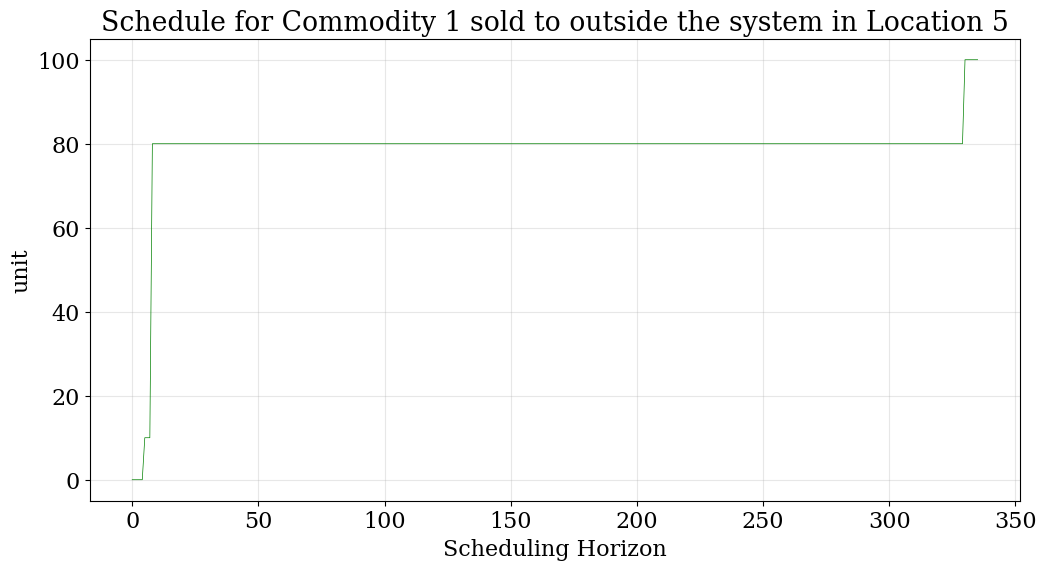

In [44]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

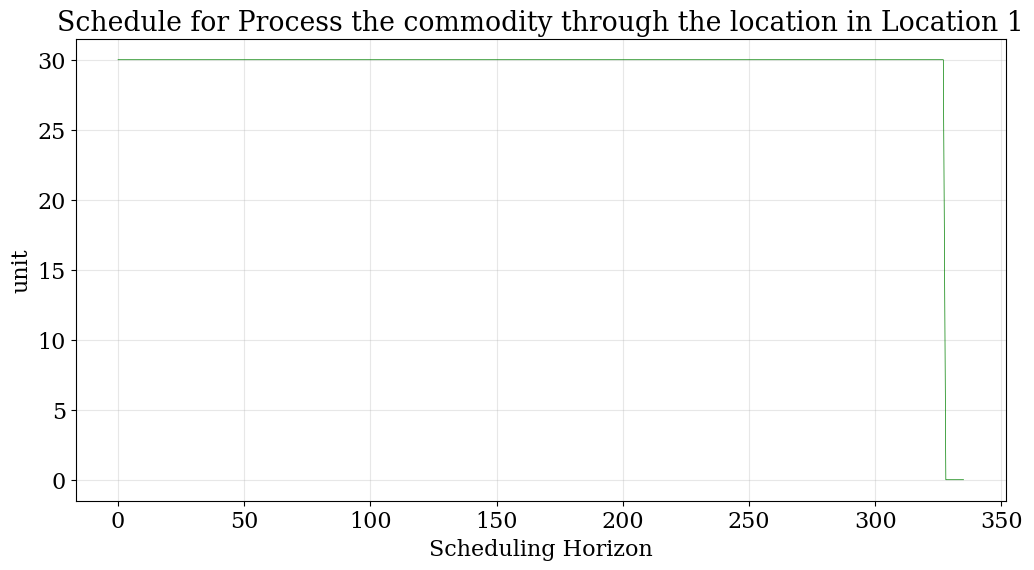

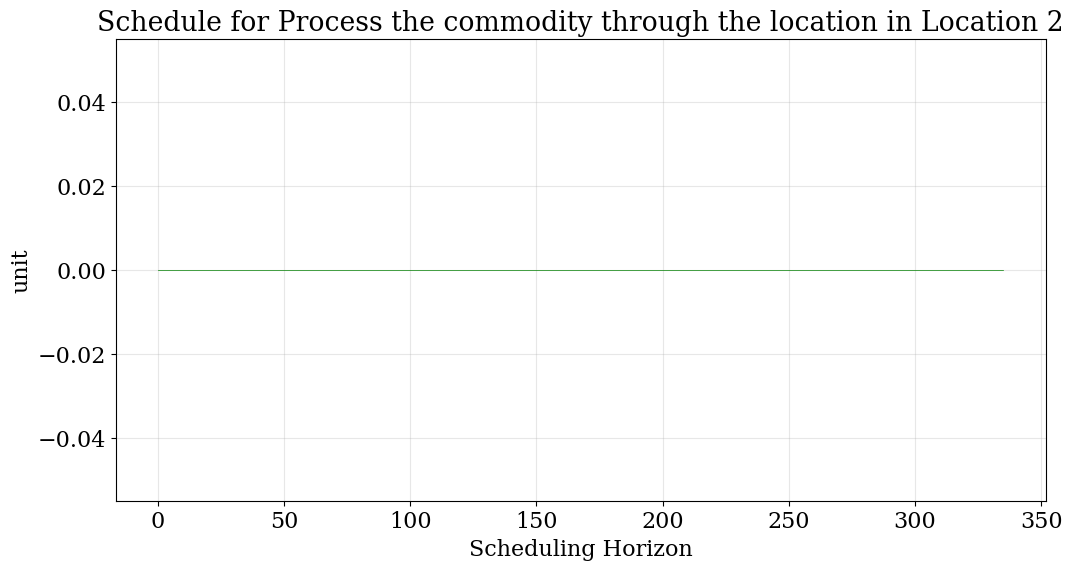

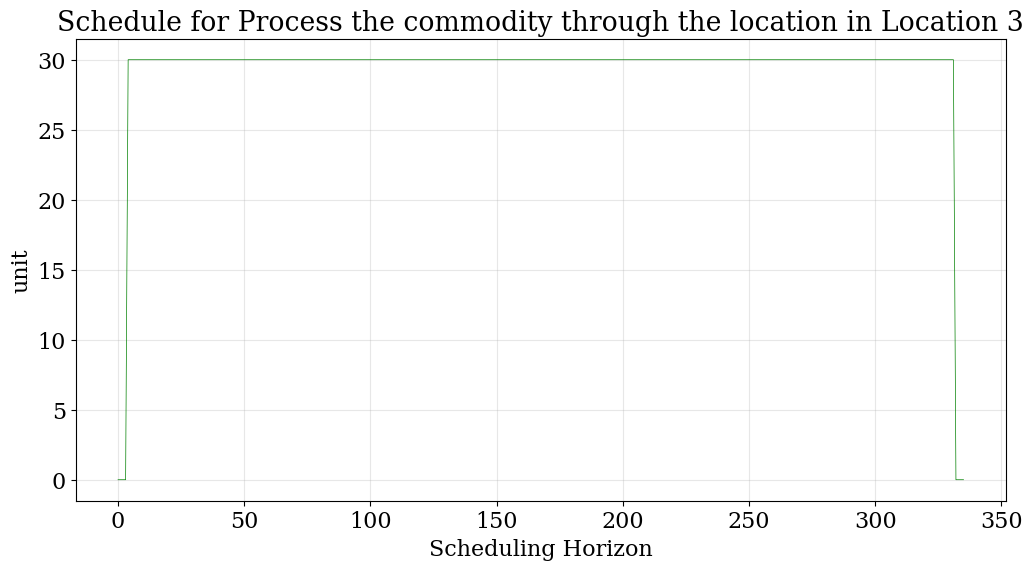

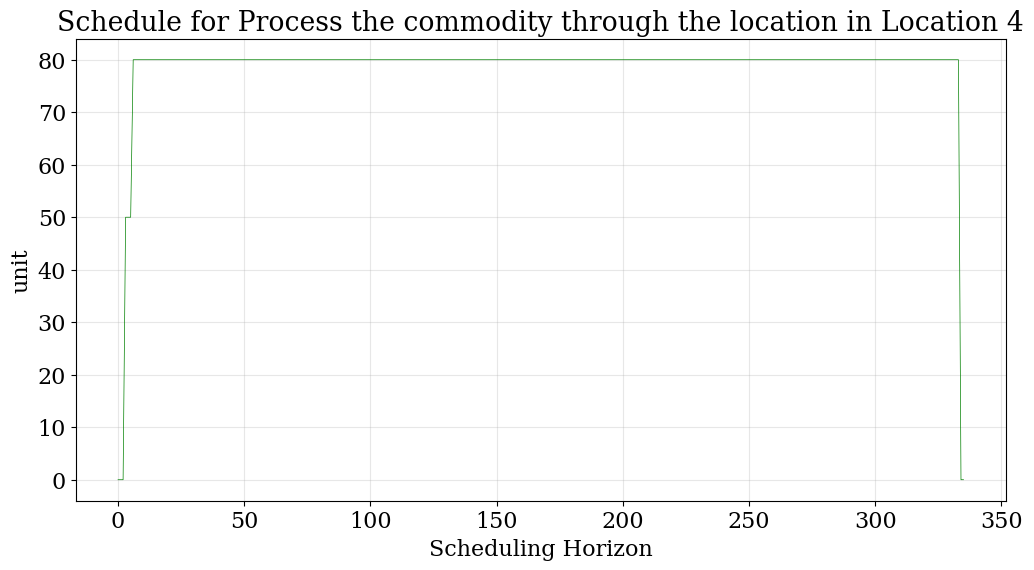

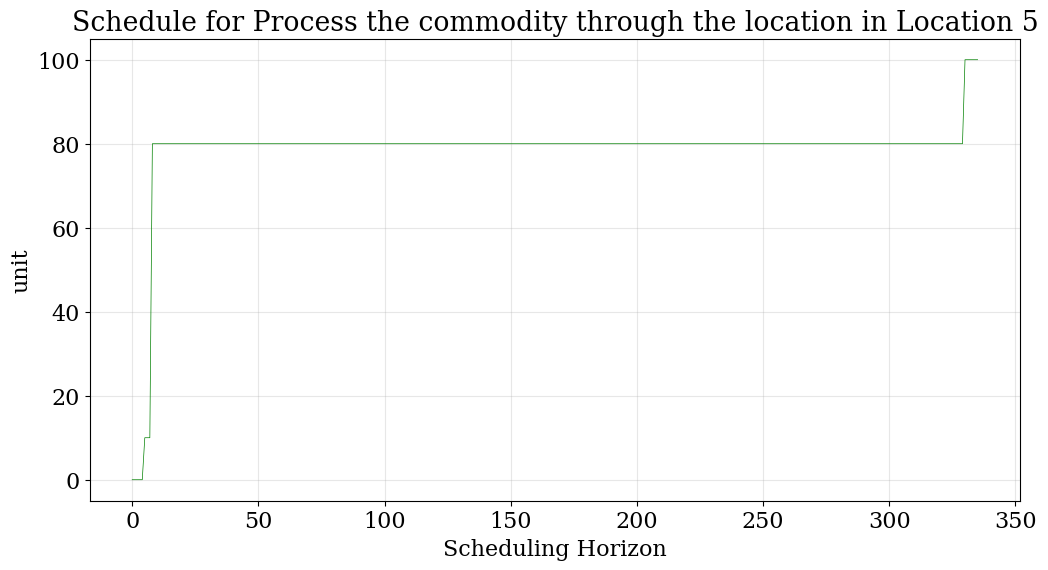

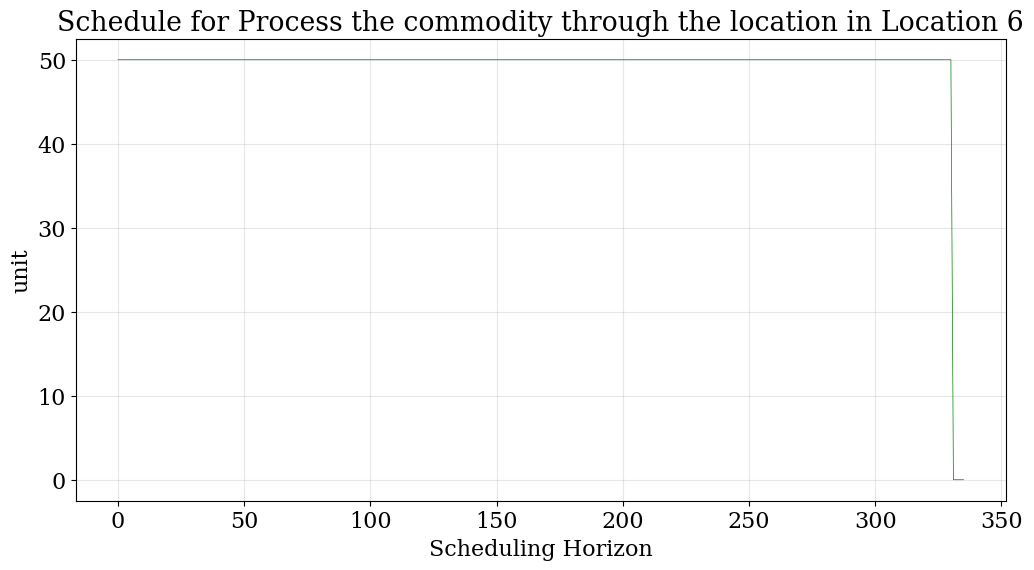

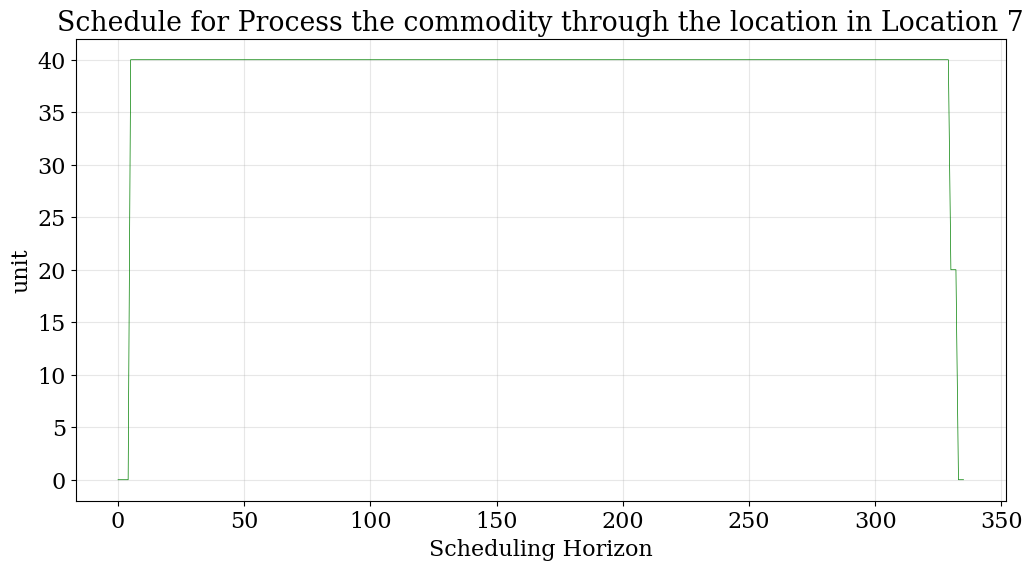

In [45]:
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc7', color='green')

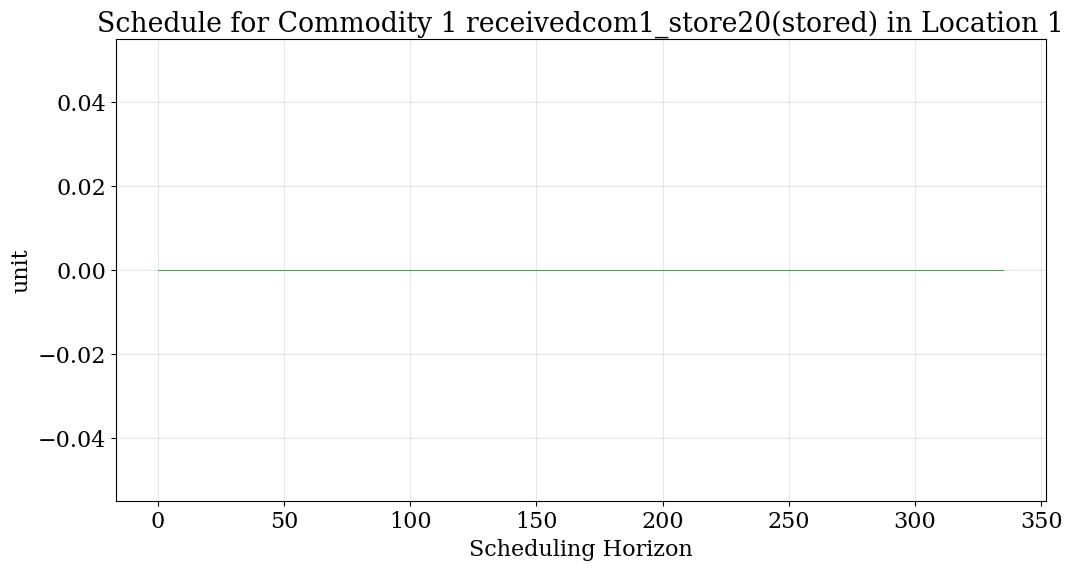

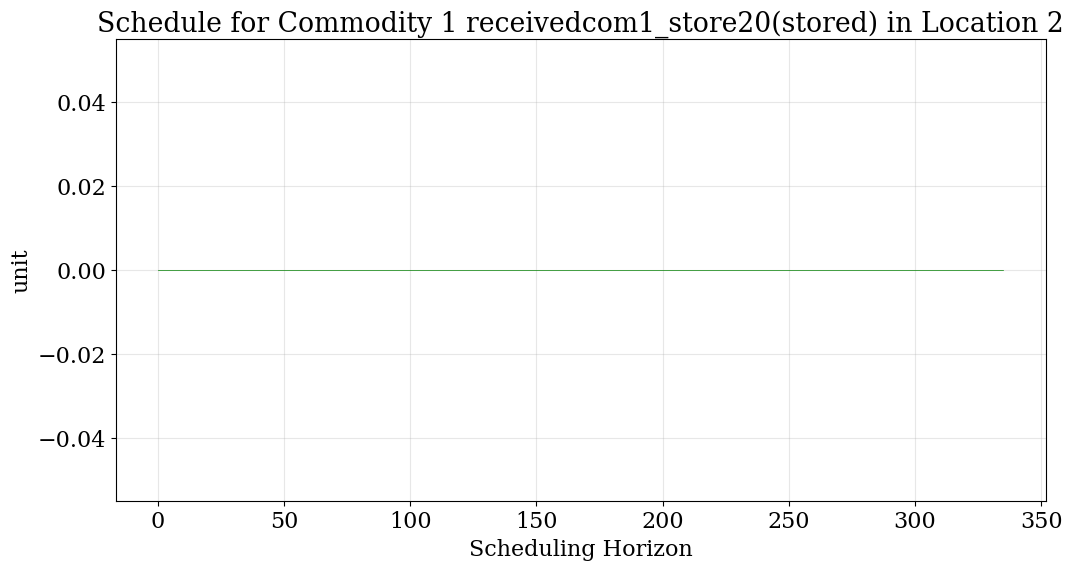

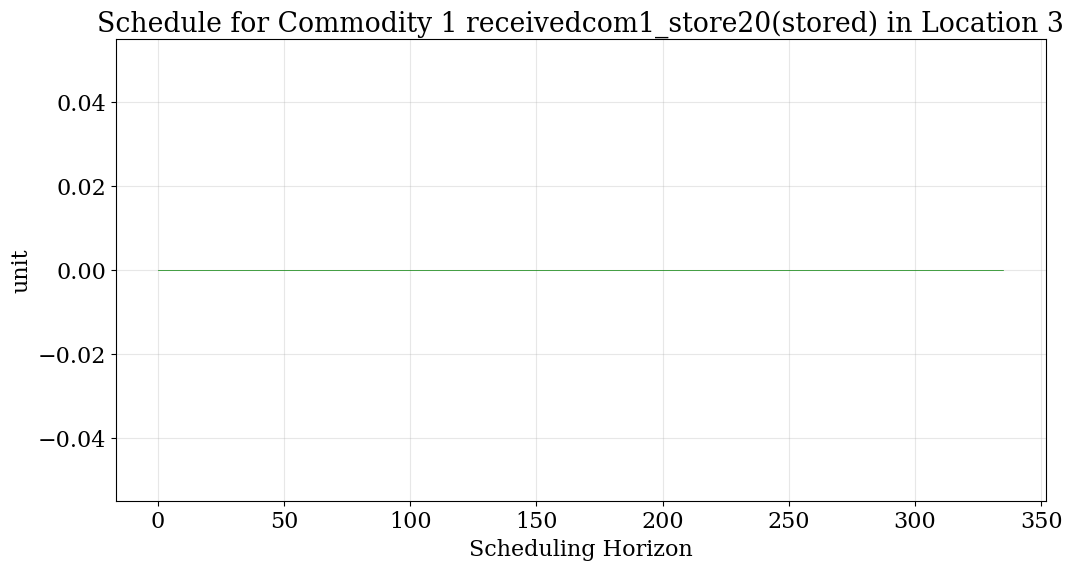

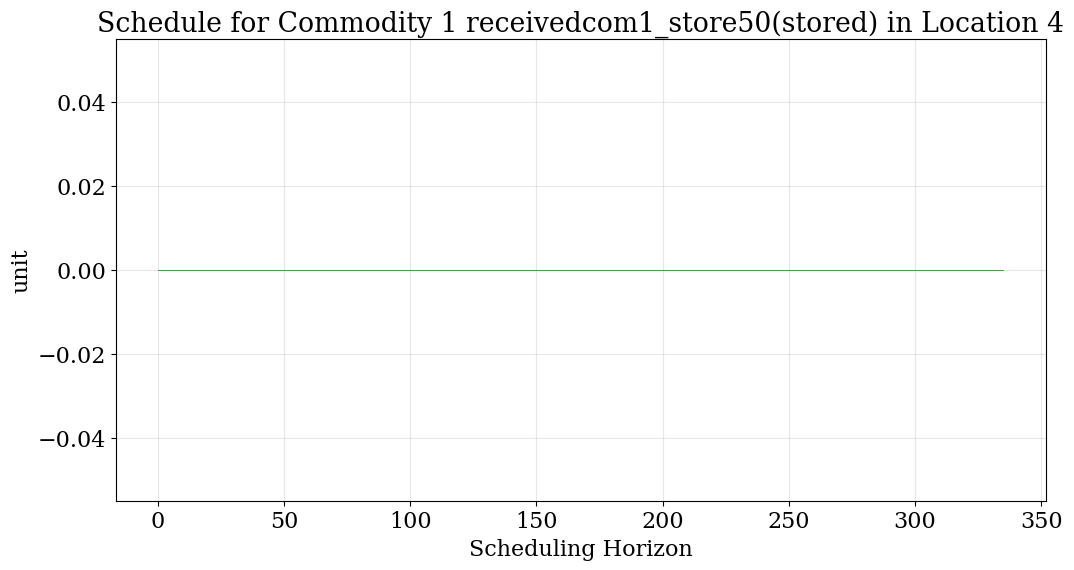

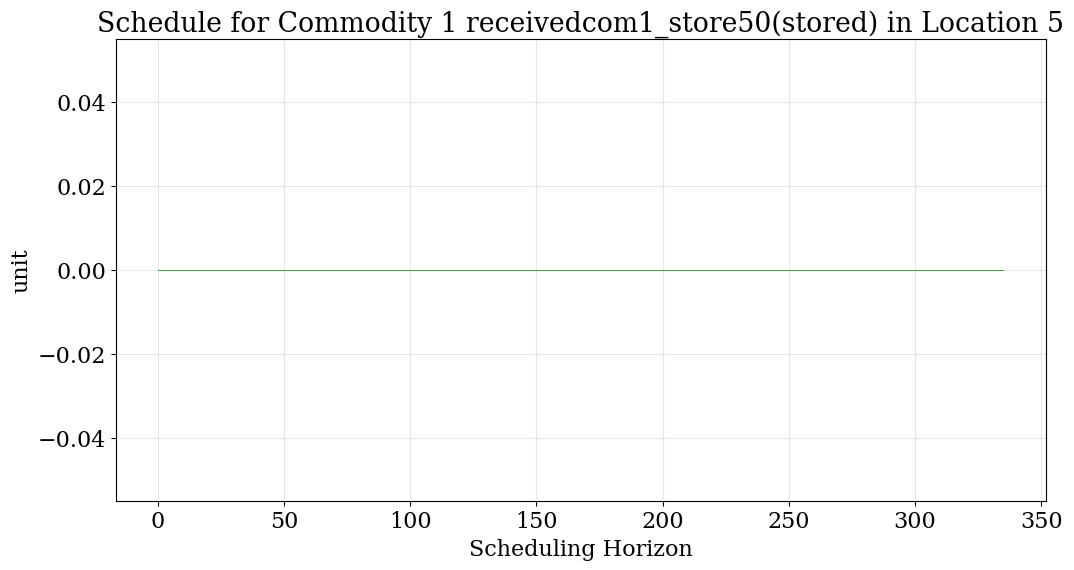

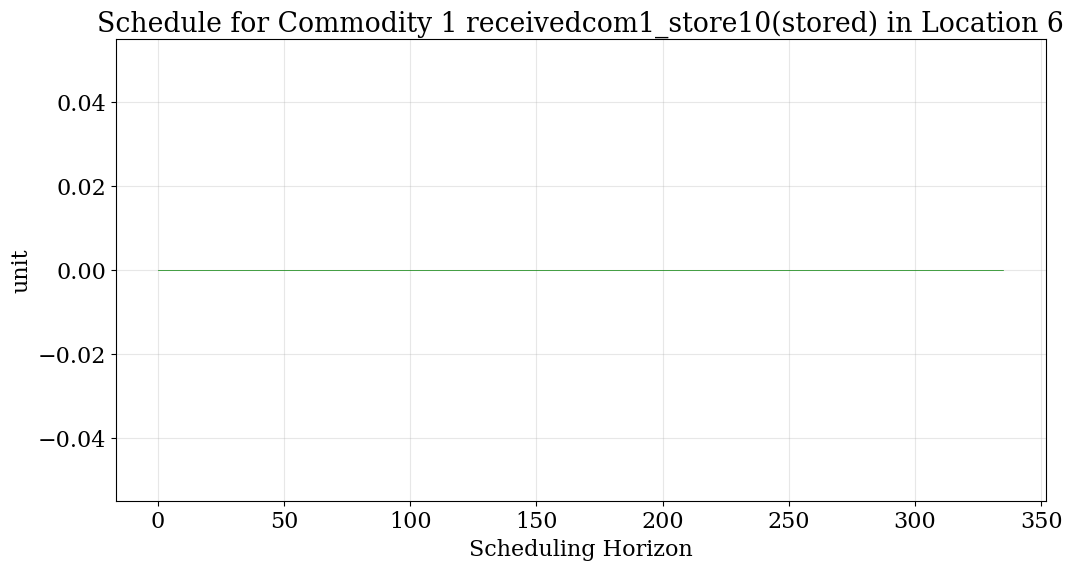

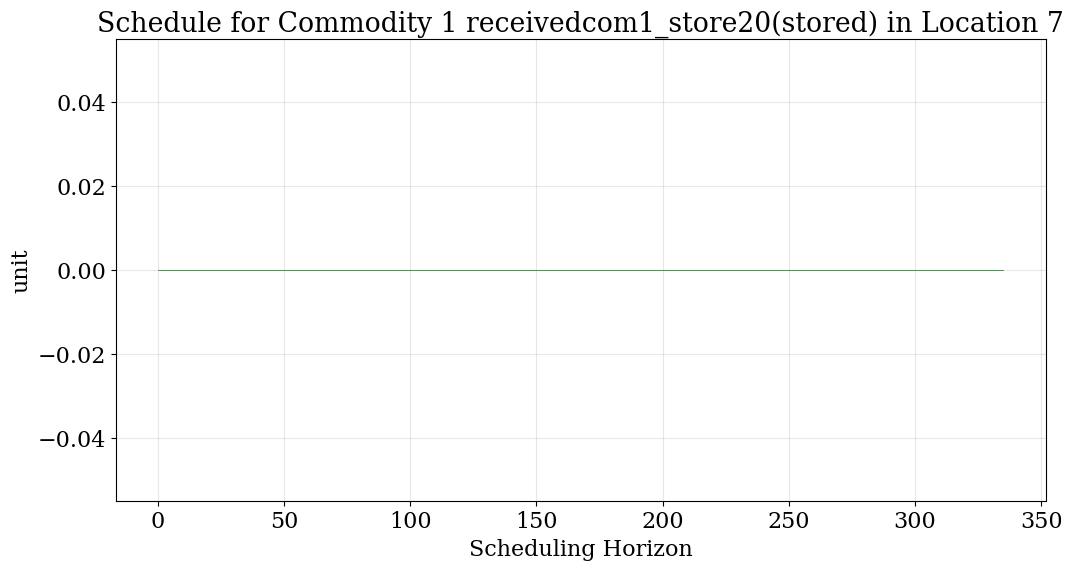

In [46]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc7', color='green')

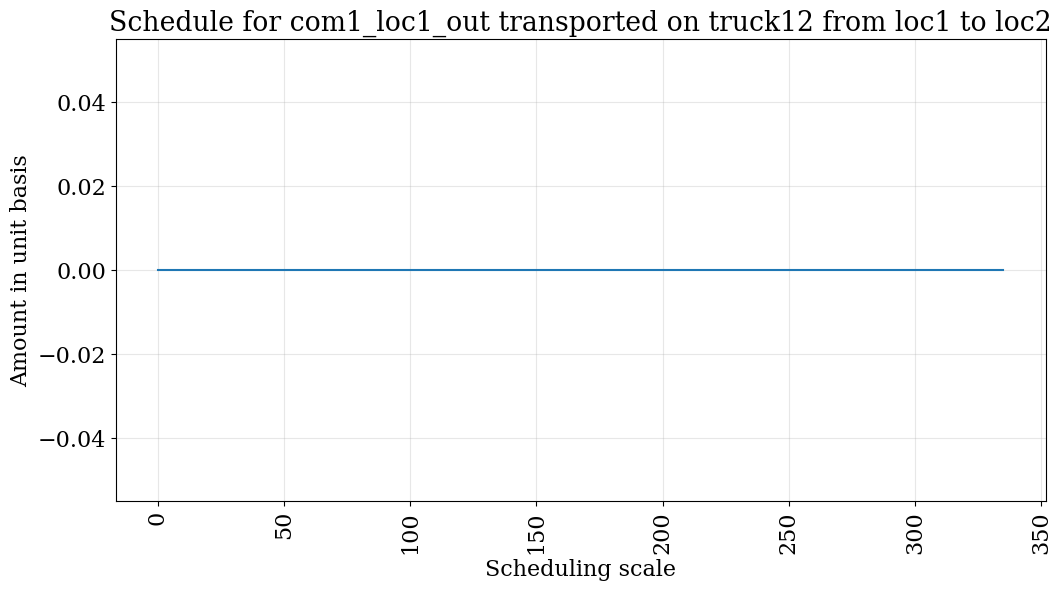

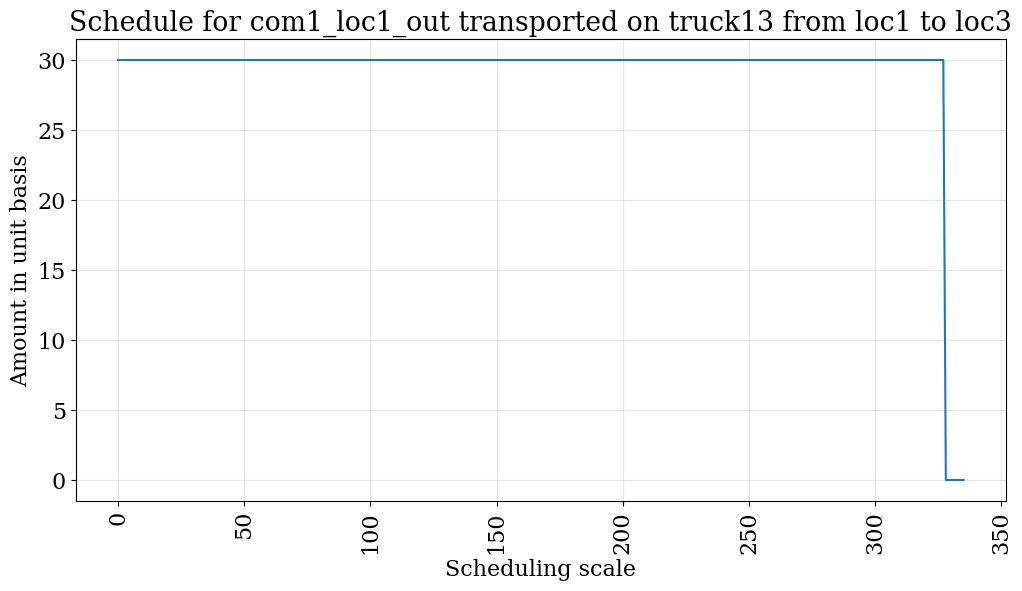

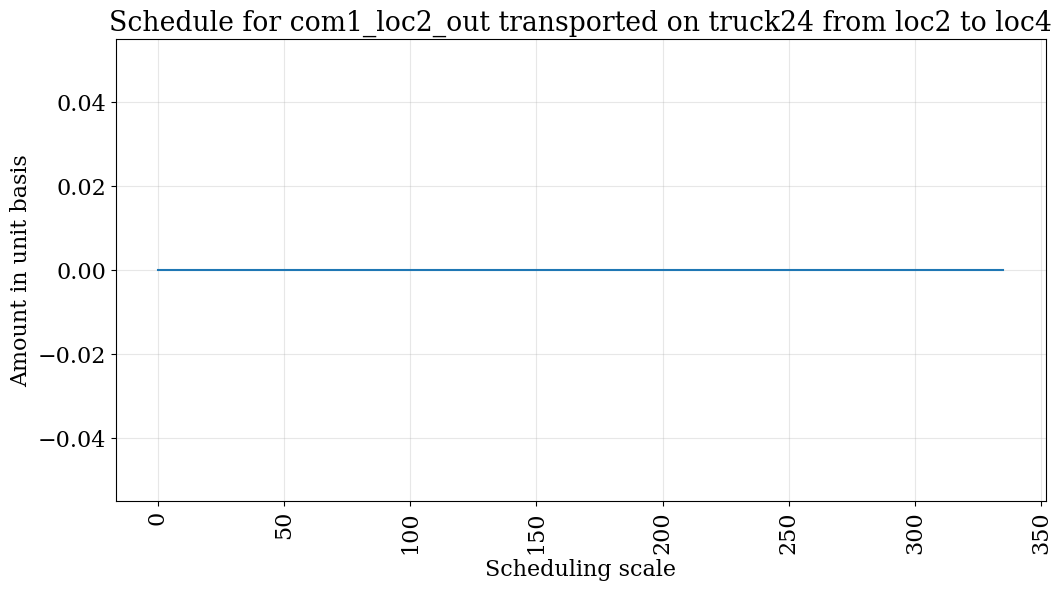

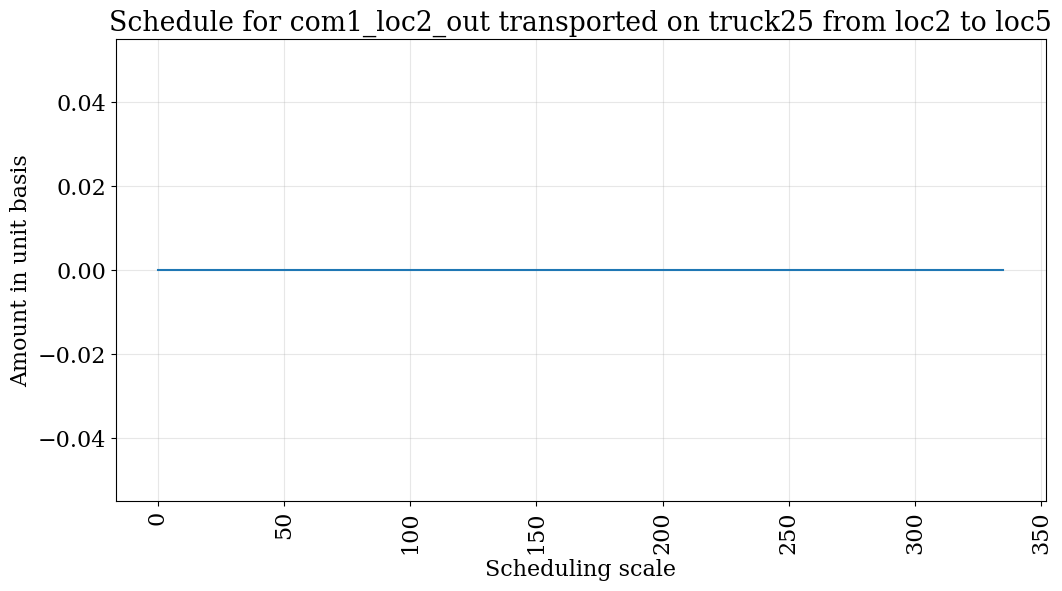

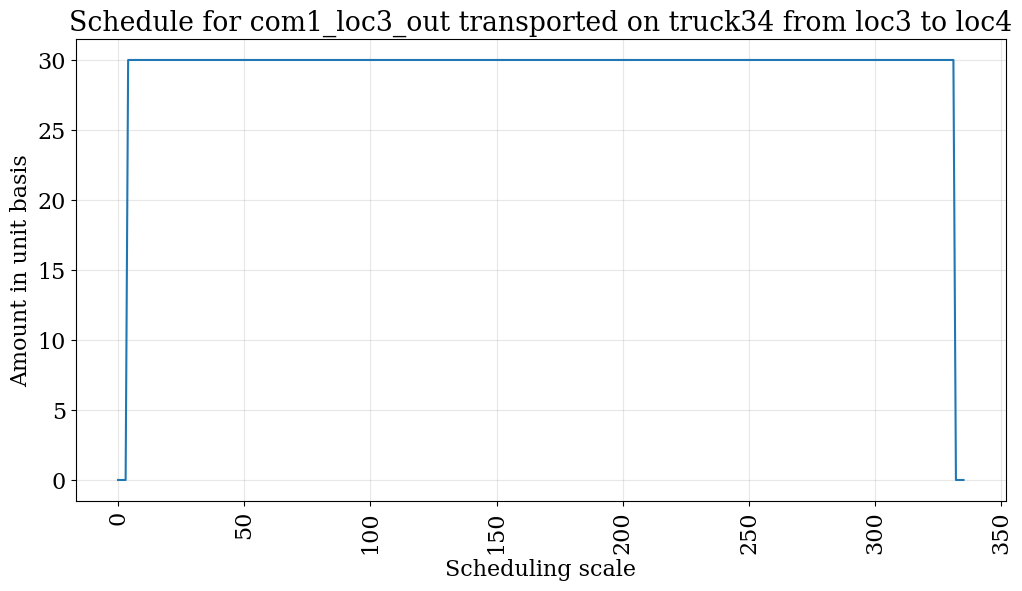

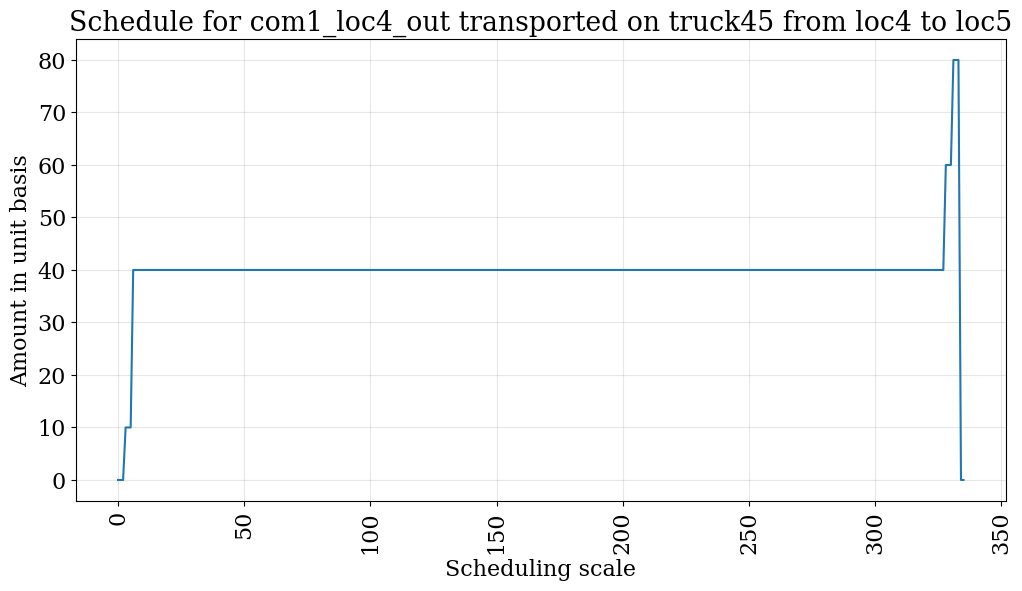

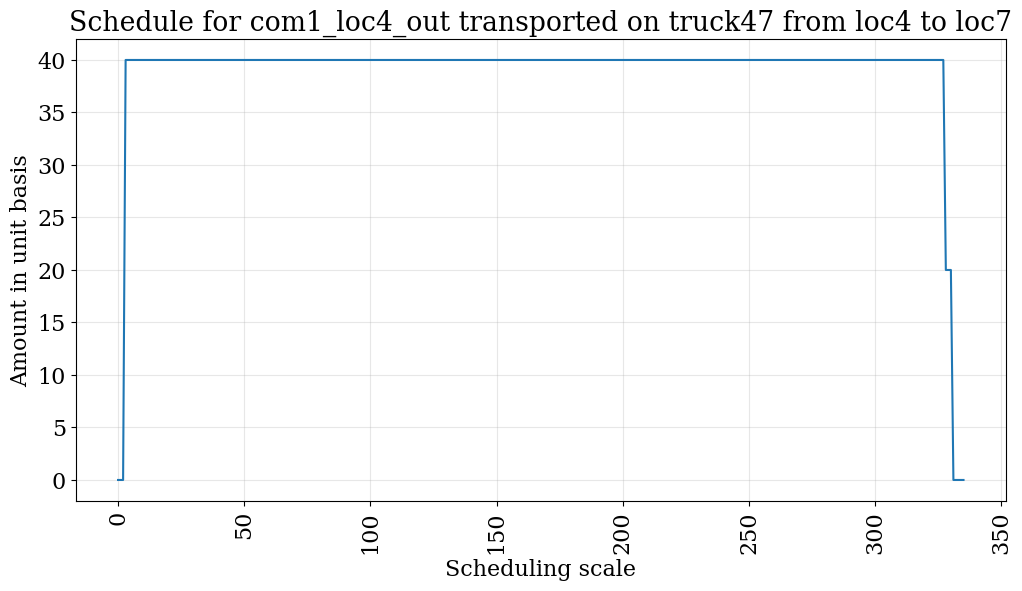

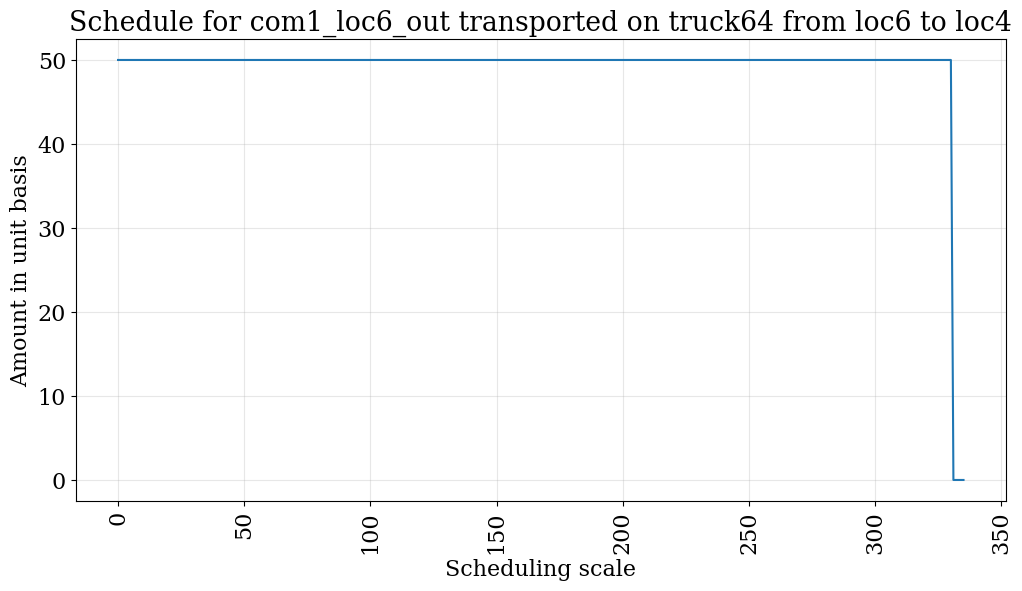

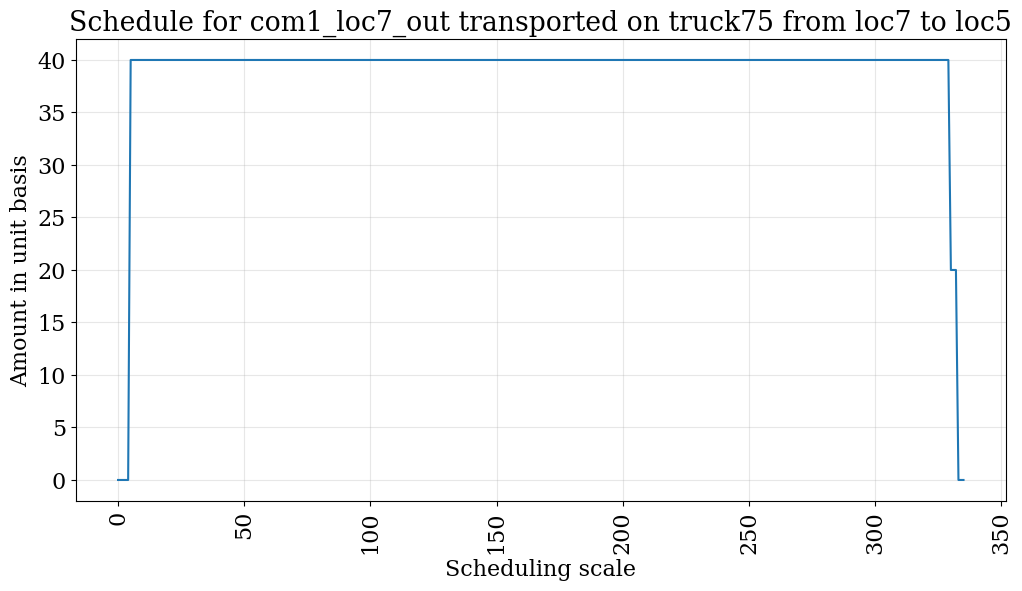

In [47]:
plot_results.transport(results=results_mincost, source='loc1', sink='loc2', resource='com1_loc1_out', transport='truck12')
plot_results.transport(results=results_mincost, source='loc1', sink='loc3', resource='com1_loc1_out', transport='truck13')
plot_results.transport(results=results_mincost, source='loc2', sink='loc4', resource='com1_loc2_out', transport='truck24')
plot_results.transport(results=results_mincost, source='loc2', sink='loc5', resource='com1_loc2_out', transport='truck25')
plot_results.transport(results=results_mincost, source='loc3', sink='loc4', resource='com1_loc3_out', transport='truck34')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', resource='com1_loc4_out', transport='truck45')
plot_results.transport(results=results_mincost, source='loc4', sink='loc7', resource='com1_loc4_out', transport='truck47')
plot_results.transport(results=results_mincost, source='loc6', sink='loc4', resource='com1_loc6_out', transport='truck64')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', resource='com1_loc7_out', transport='truck75')

In [48]:
print(*[(key, value) for key, value in results_mincost.output['Cap_F'].items() if key[0]=='loc4' and key[1]=='loc5' and value!=0], sep='\n')

(('loc4', 'loc5', 'truck45', 0), 100.0)
(('loc4', 'loc5', 'truck45', 1), 100.0)
(('loc4', 'loc5', 'truck45', 2), 100.0)
(('loc4', 'loc5', 'truck45', 3), 100.0)
(('loc4', 'loc5', 'truck45', 4), 100.0)
(('loc4', 'loc5', 'truck45', 5), 100.0)
(('loc4', 'loc5', 'truck45', 6), 100.0)
(('loc4', 'loc5', 'truck45', 7), 100.0)
(('loc4', 'loc5', 'truck45', 8), 100.0)
(('loc4', 'loc5', 'truck45', 9), 100.0)
(('loc4', 'loc5', 'truck45', 10), 100.0)
(('loc4', 'loc5', 'truck45', 11), 100.0)
(('loc4', 'loc5', 'truck45', 12), 100.0)
(('loc4', 'loc5', 'truck45', 13), 100.0)
(('loc4', 'loc5', 'truck45', 14), 100.0)
(('loc4', 'loc5', 'truck45', 15), 100.0)
(('loc4', 'loc5', 'truck45', 16), 100.0)
(('loc4', 'loc5', 'truck45', 17), 100.0)
(('loc4', 'loc5', 'truck45', 18), 100.0)
(('loc4', 'loc5', 'truck45', 19), 100.0)
(('loc4', 'loc5', 'truck45', 20), 100.0)
(('loc4', 'loc5', 'truck45', 21), 100.0)
(('loc4', 'loc5', 'truck45', 22), 100.0)
(('loc4', 'loc5', 'truck45', 23), 100.0)
(('loc4', 'loc5', 'truck45

In [49]:
print(*[(key, value) for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'], sep='\n')

(('loc5', 'com1_sold', 0, 0), 0.0)
(('loc5', 'com1_sold', 0, 1), 0.0)
(('loc5', 'com1_sold', 0, 2), 0.0)
(('loc5', 'com1_sold', 0, 3), 0.0)
(('loc5', 'com1_sold', 0, 4), 0.0)
(('loc5', 'com1_sold', 0, 5), 10.0)
(('loc5', 'com1_sold', 0, 6), 10.0)
(('loc5', 'com1_sold', 1, 0), 10.0)
(('loc5', 'com1_sold', 1, 1), 80.0)
(('loc5', 'com1_sold', 1, 2), 80.0)
(('loc5', 'com1_sold', 1, 3), 80.0)
(('loc5', 'com1_sold', 1, 4), 80.0)
(('loc5', 'com1_sold', 1, 5), 80.0)
(('loc5', 'com1_sold', 1, 6), 80.0)
(('loc5', 'com1_sold', 2, 0), 80.0)
(('loc5', 'com1_sold', 2, 1), 80.0)
(('loc5', 'com1_sold', 2, 2), 80.0)
(('loc5', 'com1_sold', 2, 3), 80.0)
(('loc5', 'com1_sold', 2, 4), 80.0)
(('loc5', 'com1_sold', 2, 5), 80.0)
(('loc5', 'com1_sold', 2, 6), 80.0)
(('loc5', 'com1_sold', 3, 0), 80.0)
(('loc5', 'com1_sold', 3, 1), 80.0)
(('loc5', 'com1_sold', 3, 2), 80.0)
(('loc5', 'com1_sold', 3, 3), 80.0)
(('loc5', 'com1_sold', 3, 4), 80.0)
(('loc5', 'com1_sold', 3, 5), 80.0)
(('loc5', 'com1_sold', 3, 6), 80.

In [51]:
problem_mincost.constraint_inventory_balance['loc5', 'com1_sold', 46, 0].pprint()

{Member of constraint_inventory_balance} : mass balance across scheduling scale
    Size=32928, Index=locations*resources*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}*{0, 1, 2, 3, 4, 5, 6}, Active=True
    Key                          : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [53]:
problem_mincost.constraint_inventory_balance['loc5', 'com1_loc5_out', 46, 0].pprint()

{Member of constraint_inventory_balance} : mass balance across scheduling scale
    Size=32928, Index=locations*resources*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}*{0, 1, 2, 3, 4, 5, 6}, Active=True
    Key                              : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [56]:
problem_mincost.P_m['loc5','sell com1',0,46,0].pprint()

{Member of P_m} : Production modes
    Size=54096, Index=locations*{('com1_loc6_send', 0), ('com1_receive_loc6', 0), ('com1_loc7_send', 0), ('com1_receive_loc4', 0), ('com1_store50', 0), ('com1_receive_loc1', 0), ('com1_store10_discharge', 0), ('com1_store20_discharge', 0), ('procure com1', 0), ('com1_store10', 0), ('com1_loc2_send', 0), ('com1_receive_loc7', 0), ('com1_store20', 0), ('com1_receive_loc5', 0), ('sell com1', 0), ('com1_loc3_send', 0), ('com1_loc4_send', 0), ('com1_process', 0), ('com1_store50_discharge', 0), ('com1_receive_loc2', 0), ('com1_loc5_send', 0), ('com1_loc1_send', 0), ('com1_receive_loc3', 0)}*scales_scheduling
    Key                             : Lower : Value : Upper : Fixed : Stale : Domain
    ('loc5', 'sell com1', 0, 46, 0) :     0 :  80.0 :  None : False : False : NonNegativeReals
